# History of Philosophy
#### Ranran Tao

Philosophy is a diverse and rich field that has thousands of years of history with a wide range of ideas and thoughts. From ancient Greeks to the modern day, it produces critical thinkers, communicators, as well as theories and arguments that have shaped our understanding of the world. This analysis aims to offer all levels of audience a unique perspective on the history of philosophy, using data mining, statistical analysis and visualization on <a href="https://www.kaggle.com/datasets/kouroshalizadeh/history-of-philosophy?resource=download" target="_blank">the philosophy dataset</a>. The dataset has over 300,000 sentences said by philosophers from 13 schools of philosophy: Plato, Aristotle, Stoicism, Rationalism, Empiricism, German Idealism, Nietzsche, Communism, Capitalism, Phenomenology, Continental, Analytic, and Feminism. We will firstly look at the main philosophy topics, discuss the sentiment of these philosophy texts, examine the sizes of the text content in each school, and finally see how the philosophy has developed over thousand of years. 

In [1]:
import pandas as pd
import ast
#!pip install nltk
import nltk
nltk.download('punkt',quiet=True)
nltk.download('stopwords',quiet=True)
from nltk.corpus import stopwords
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install textblob
from textblob import TextBlob
import numpy as np
#!pip install h2o
import h2o
from h2o.estimators import H2OWord2vecEstimator, H2OGradientBoostingEstimator
# To install in the root environment
#!pip install -U scikit-learn
#!pip install sklearn
import sklearn
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.pyplot import *

In [2]:
df = pd.read_csv('../data/philosophy_data.csv') #read data
#df.head()

## What is the main philosophy in each school?

If you are not familiar with philosophy, you probabily only heard of Plato or Aristotle. When it comes to philosophy, the first thing you might be wondering is: what are the main thoughts in the history of philosophy? To answer this question, let us firstly take a look at the wordclouds of each major school of thoughts and then look at the five main topics in the entire history of philosophy. I believe that this can help us get an initial general concept of philosophy.

In [3]:
schools = df.school.unique().tolist()
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english') #stopwords.append("n't")
stopwords.extend(['from', 'one', 'let', 'shall', 'use','would','may','also','always'])
#print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
#print (stopwords[:10])

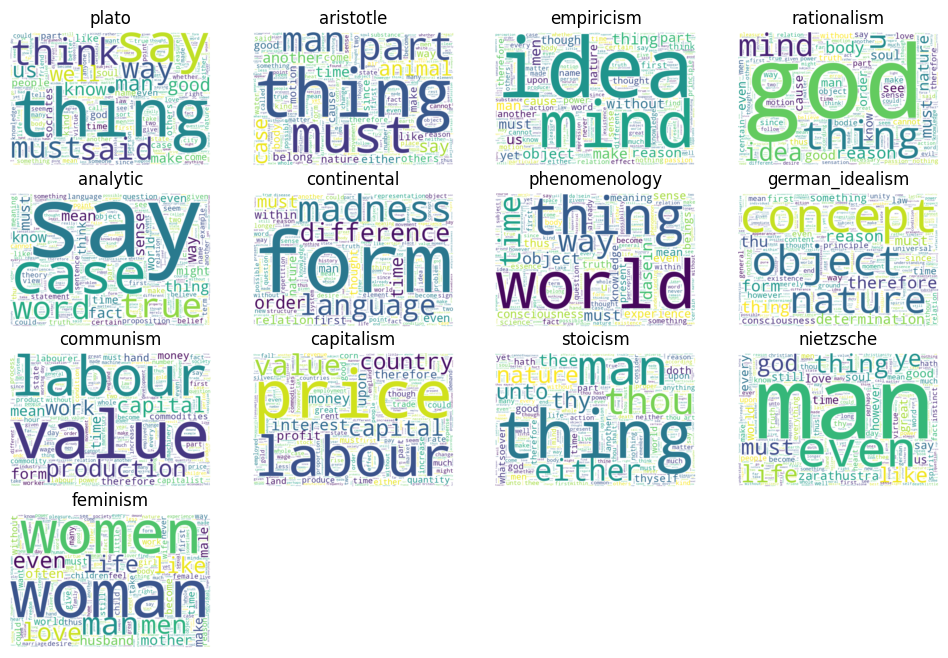

In [4]:
fig, ax = plt.subplots(4, 4, figsize=(12, 8))
i = 0
for row in range(4):
    for col in range(4):
        i = row*4 + col
        if i <= 12: 
            df_temp = df[df.school==schools[i]]
            # render wordcloud
            text = " ".join(txt for txt in df_temp.sentence_lowered)
            wordcloud = WordCloud(stopwords=stopwords, max_font_size=300, max_words=1000,
                                  width = 600, height = 400,
                                  background_color="white").generate(text)
            ax[row,col].imshow(wordcloud, interpolation="bilinear")
            ax[row,col].set_title(str(schools[i]))
            ax[row,col].axis("off")
        else:
            ax[row,col].set_visible(False)

The wordclouds give us a visual representation of the most frequent words in philosophy text for each school. We can see that:

- **Empiricism**: talked a lot about "idea", "object", "nature", "reason", "cause" as it emphasizes the importance of observation and experience as the primary means of acquiring knowledge.

- **Rationalism**: talked a lot about "god", "mind", "soul", "idea" as it emphasizes the innate ideas and concepts as the primary means of acquiring knowledge.

- **Analytic**: talked a lot about "say", "case", "fact", "word", "true" as it emphasizes reasoning, logic analysis and truth.

- **Continental**: talked a lot about "form", "language", "structure", "madness" as it emphasizes the role of language in creating meaning and understanding, and the way in which language shapes our perception of the world, and is often associated with structuralism.

- **Phenomenology**: talked a lot about "world", "time", "experience", "fact" as it emphasizes that the objects of experience should be studied as they appear to us.

- **German Idealism**: talked a lot about "concept", "consciousness", "nature", "object", "reason" as it emphasizes the importance of self-consciousness. 

- **Communism**: talked a lot about "labour", "value", "production", "money", "work" as it holds that a society should be organized in an equal and fair way. All property is publicly owned and each person works and is paid according to their abilities and needs.

- **Capitalism**: talked a lot about "price", "capital", "labour", "interest" as it describes an economic system in which the means of production, distribution, and exchange are privately or corporately owned and operated for profit. 

- **Stoicism**: talked a lot about "man", "nature", "proper", "good", "action" as it emphasizes the self-control. 

- **Nietzsche**: talked a lot about "man", "virtue", "spirit" as it critiques traditional virtues.

- **Feminism**: talked a lot about "women", "husband", "mother", "love", "marriage" as it emphasizes women's rights, which might be reflected in marriage, family and other occasions.

The wordclouds for **Plato** and **Aristotle** did not show many descriptive words that represent their philosophy. Most of the words are "say", "thing", "man". It might be explained by the fact that their philosophy was older and they tend to use easier and less distinct words. Also, Aristotle was a student of Plato, so his philosophy and sentence style was heavily influenced by his mentor. So, it is difficult for the wordcloud to show the main topic behind their philosophy for Plato and Aristotle.

To discover what Plato and Aristotle said, I changed my analysis method to overcome the limitation of wordcloud. Instead of using wordcloud, I used tf-idf matrix to reflect the word frequency, and Latent Dirichlet allocation for clstering to reflect the 5 main topics in the philosophy text. This way can provide more detailed information on Plato's/Aristotle's philosophy.

In [5]:
from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer 
stemmer = SnowballStemmer("english")
# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())
    filtered_tokens = []    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')

tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(df[df['school']=='plato'].sentence_lowered) #fit the vectorizer to synopses
#print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
#      " sentences and " + str(tfidf_matrix.shape[1]) + " terms.")

In [7]:
# words
tf_selected_words = tfidf_model.get_feature_names()

In [8]:
# Use LDA for clustering
# n_components=5：set 5 topic
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5)

In [9]:
# document topic matrix for tfidf_matrix_lda
lda_output = lda.fit_transform(tfidf_matrix)
#print(lda_output.shape)
#print(lda_output)

In [10]:
# topics and words matrix
topic_word = lda.components_
#print(topic_word.shape)
#print(topic_word)

In [11]:
# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]
# index names
doc_names = ["Doc" + str(i) for i in range(len(df[df['school']=='plato'].sentence_lowered))]
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic
#df_document_topic.head(10)

In [12]:
# topic word matrix
#print(lda.components_)
# topic-word matrix
df_topic_words = pd.DataFrame(lda.components_)
# column and index
df_topic_words.columns = tfidf_model.get_feature_names()
df_topic_words.index = topic_names
#df_topic_words.head()

In [13]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=15)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

Word 0 Word 1 Word 2    Word 3   Word 4 Word 5  Word 6    Word 7  \
Topic 0     say  thing  right      agre  certain  anyth  reason     speak   
Topic 1    said  peopl   time       god     look  state  friend      want   
Topic 2   think    way    man      come     mean   tell   anoth    suppos   
Topic 3  socrat   know   case  knowledg    point   like  answer  question   
Topic 4    good   soul   citi      make      law  natur    mani    differ   

         Word 8    Word 9     Word 10  Word 11  Word 12 Word 13 Word 14  
Topic 0     els      turn  understand  possibl   someon    word     far  
Topic 1   clear      fact        noth   realli    place    kind  togeth  
Topic 2    love  argument         yes     true   believ    life  justic  
Topic 3  follow    better     discuss   matter  thought    fine  speech  
Topic 4    sort     thing         men  pleasur      bad     tri  someth

Above is the 5 main topics of the **Plato** school. Each topic has 15 most descriptive words. Here we can see what Plato school mostly talked about:

- **Topic 1**: word "realli", "place", "state", "people" reflects that Plato school describes somthing about politics. It might discussed many things centered around 'how an ideal state should operate', 'people should perform what roles'. 
- **Topic 2**: word "justic", "true", "life" reflects that Plato school emphasizes justice, which is an aspect of good life. 
- **Topic 3**: word "knowledge", "question", "answer", "socrat" reflects that Plato school has many theories of knowledge, and Plato is closely associated with Socrates.
- **Topic 4**: word "soul", "natur" reflects that Plato school has many theories of nature of the soul.

We can also gain a rough understanding of what Aristotle school mostly talked about by doing the same way. Since this method is highly reproducible, and I aim to have my analysis covering more perspectives while keeping it concise, I would like to omit this part.  

# What is the sentiment in philosophy of each school?

After knowing the main philosophy in each school, we might start wondering, what is the sentiment in these philosophy texts? Does each school have different emotions? Here I did sentiment analysis for sentences from each school and visualized it for you to compare.

In [14]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

dfsent = df.copy()
dfsent['polarity_score']=dfsent['sentence_lowered'].apply(lambda x : polarity(x))

In [15]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'

dfsent['polarity']=dfsent['polarity_score'].map(lambda x: sentiment(x))
#plt.bar(dfsent.polarity.value_counts().index, dfsent.polarity.value_counts())

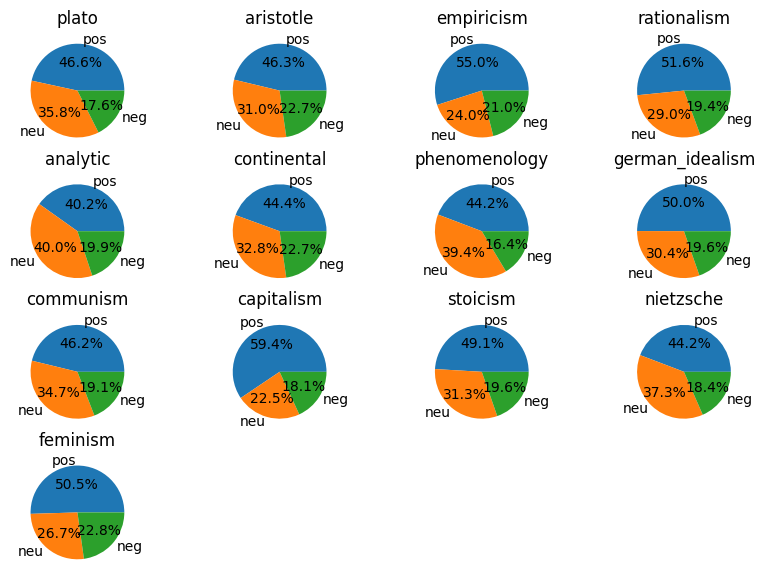

In [16]:
labels = ["pos", "neu", 'neg']
fig, ax = plt.subplots(4,4,figsize=(10, 7))
i = 0
cnt = []
for sch in schools:
    dfsent_temp = dfsent[dfsent['school']==sch]
    cnt.append(dfsent_temp.polarity.value_counts())

for row in range(4):
    for col in range(4):
        i = row*4 + col
        if i <= 12:    
            ax[row,col].pie(cnt[i].tolist(), labels=labels, autopct='%.1f%%')
            ax[row,col].set_title(str(schools[i]))
            ax[row,col].axis("off")
        else:
            ax[row,col].set_visible(False)

Looking at the pie chart of sentiment by school, we can see that a positive emotion is dominant in the philosophy text of every school, and comes after positive is neutrual emotion. Negative emotion tends to be the least. A fun finding is that **Capitalism** and **empiricism** are the most "positive" schools, while **feminism**, **aristotle**, **continental** tends to be more "pessimistic" than other schools. It could possibly be explained by the fact that aristotle rejected many Plato's theories, continental did many rejections on the view that the natural sciences are the best way of understanding all phenomena, feminism rejects many things, like gender inequality, Patriarchy, Stereotypes and biases.

# How much did they say in each school?

After examing the ideas and sentiment of philosophy in each school, let us now explore how much they said in each school. I first visualized the average sentence length by school, then looked at the philosophers who said the most sentences in each school.

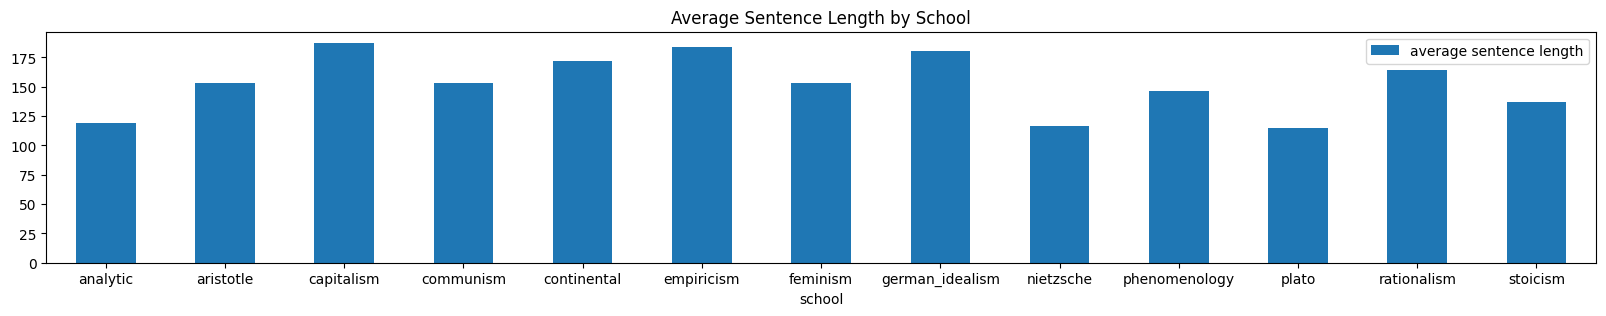

In [17]:
dfsent_len = df.copy()
avglen = dfsent_len.groupby('school')['sentence_length'].mean().reset_index()
ax = avglen.plot.bar(x='school', y='sentence_length', rot=0, figsize=(20, 3), title='Average Sentence Length by School')
ax.legend(['average sentence length'])

Looking at the overall trend, the average sentence length for all the schools is centered around 100 to 200 words per sentence. **Capitalism**, **continental**,  **empiricism**, **german idealism** have the longest average sentence length, while **Analytic**, **Nietsche**, **Plato** have the shortest average sentence length. 

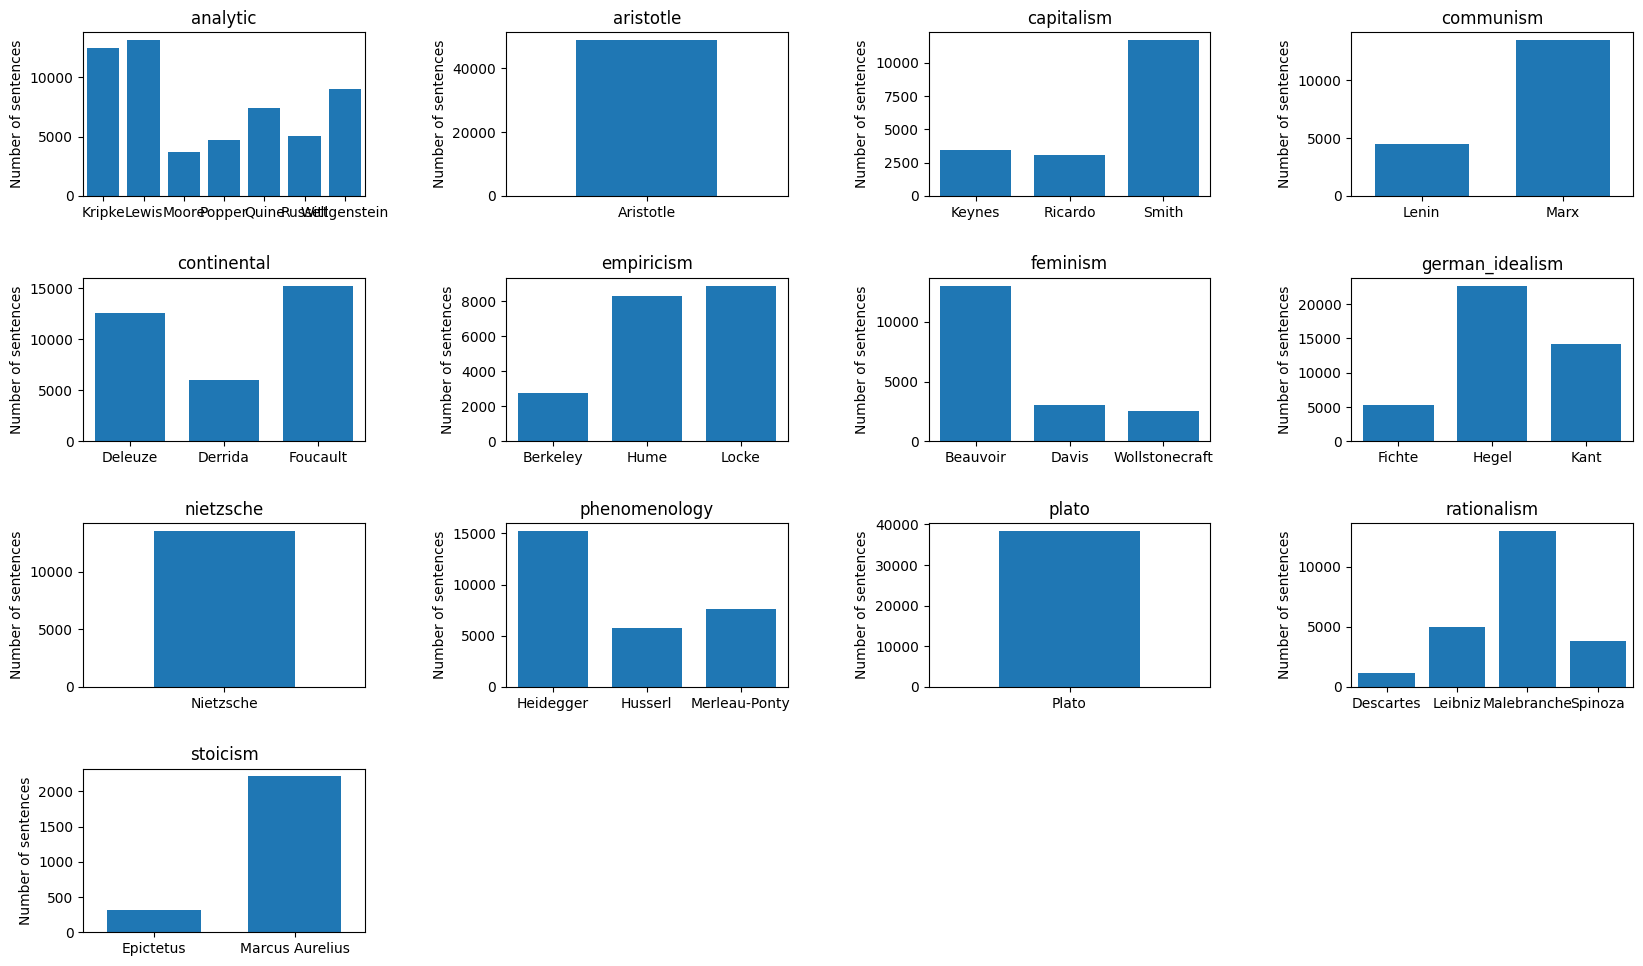

In [27]:
people=dfsent_len.groupby(['school','author'])['sentence_lowered'].count().reset_index()
fig, ax = plt.subplots(4,4,figsize=(20, 10))
subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=1, wspace=0.5, hspace=0.5)
i = 0
author = []
autcnt = []
for sch in people.school.unique():
    people_temp = people[people['school']==sch]
    autcnt.append(people_temp.sentence_lowered)
    author.append(people_temp.author)

for row in range(4):
    for col in range(4):
        i = row*4 + col
        if i <= 12:   
            people_temp = people[people['school']==people.school.unique()[i]]
            ax[row,col].bar(author[i], autcnt[i], align='center', width=min(1-1/(len(autcnt[i])+1), 0.8))
            ax[row,col].set_title(people.school.unique()[i])
            ax[row,col].set_xlim(-0.5, len(autcnt[i])-0.5)
            ax[row,col].set_ylabel('Number of sentences')
            #ax[row,col].axis("off")
        else:
            ax[row,col].set_visible(False)

We can see that some schools recorded only one philosopher's sentences (**Aristotle**, **Plato**, **Nietzsche**), the other schools recorded multiple philosophers' sentences. **Analytic** has the largest number of philosophers, among them Lewis and Kripke said the most sentences. Additionally, Smith, Marx, Foucault, Hume, Locke, Beauvoir, Hegel, Heidegger, Malebranche, Marchs Aurelius are all important philosophers who made major contributions to their corresponding schools in terms of number of sentences. 

# How has philosophy developed over time?

We now have a general idea of the main topics, sentiment, speech in philosophy, let us move on to the last section that I would like to lead you to explore: How has the philosophy evolved over time? Here, we can finally put each school's philosophy into the context of history. We will first look at the original publication year of the books in each school, then look at the corpus edition years of them.

In [19]:
time = dfsent_len.groupby(['school','original_publication_date'])['title'].nunique().reset_index()
time = time.sort_values('original_publication_date').reset_index()

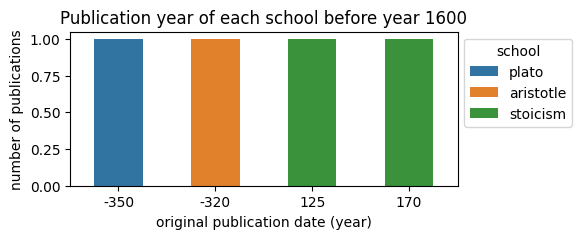

In [20]:
plt.figure(figsize=(5,2))
plt.title('Publication year of each school before year 1600')
plot2 = sns.barplot(x="original_publication_date", y="title", hue="school", data=time[:4],dodge=False,width=0.5)
plot2.set(xlabel='original publication date (year)',ylabel='number of publications')
sns.move_legend(plot2, "upper left", bbox_to_anchor=(1, 1))

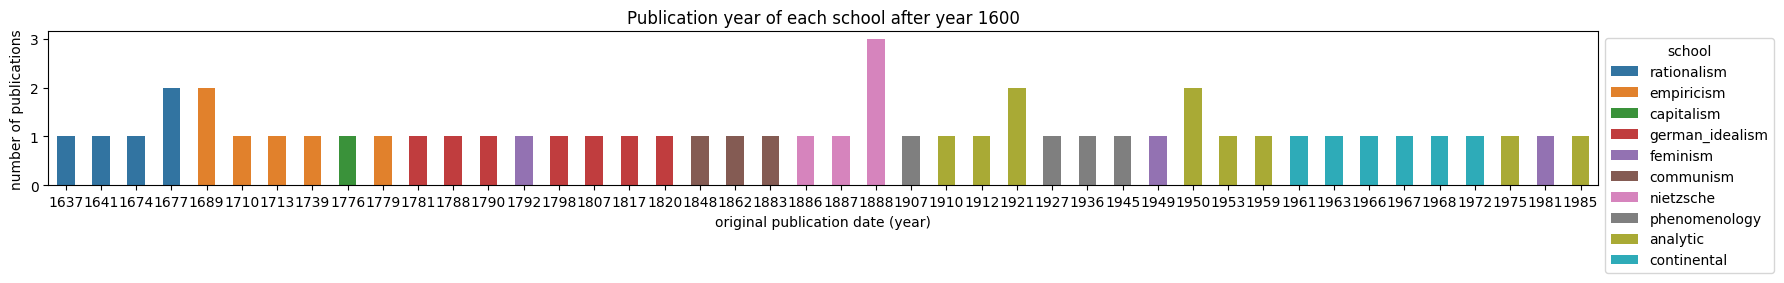

In [21]:
plt.figure(figsize=(20,2))
plt.title('Publication year of each school after year 1600')
plot2 = sns.barplot(x="original_publication_date", y="title", hue="school", data=time[4:],dodge=False,width=0.5)
plot2.set(xlabel='original publication date (year)',ylabel='number of publications')
sns.move_legend(plot2, "upper left", bbox_to_anchor=(1, 1))

I divided the timeline into two parts：350 BC - 170 AD，1637 AD - 1985 AD, since there was a large gap between 170 AD to 17th century, during which no original publication for philosophy books was seen in our dataset. It shows that **Plato** is the earliest while **Analytic** is the latest among 13 schools of thoughts in our dataset. From 350 BC to 170 AD, the world saw a brief flourishing of philosophy, then after more than a thounsand years, started from the 17th century, the world saw another longer flourishing period of philosophy. It could possibly be explained by the historical background that the Scientific Revolution occurred during this time, which fundamentally changed the way people thought about the natural world. During this period, many philosophers, like **Rationalism** philosophers, began to question the traditional Aristotelian view of the world, which had been dominant for centuries. They began to develop new ideas about the natural world that were based on observation, experimentation, and reason, rather than on tradition and authority.

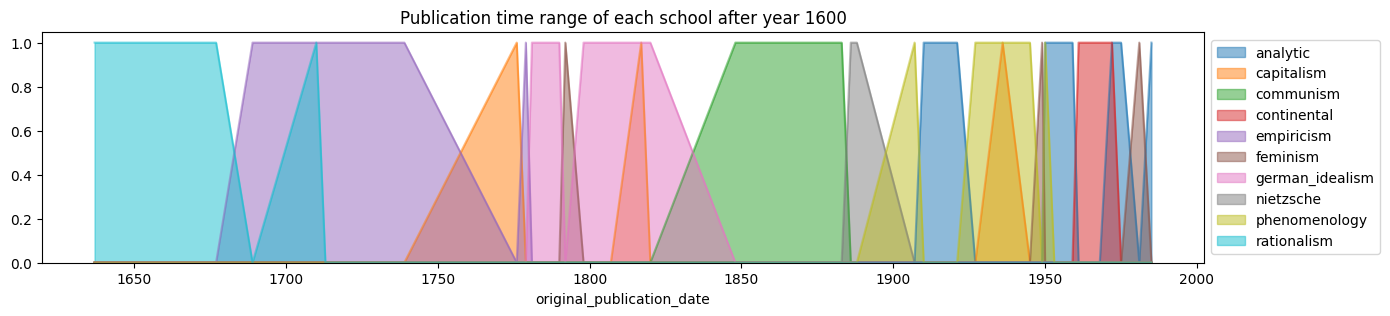

In [22]:
timeplt = time[4:].value_counts(['school','original_publication_date'])
timeplt.unstack('school').fillna(0).plot.area(stacked=False,figsize=(15, 3),title='Publication time range of each school after year 1600').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

From above figure, we can roughly see the philosophy books original publication period for each school of thoughts after year 1637. Some schools, like **Empiricism**, has a long time span of publishing books (1689-1739, published 5 books in 50 years), and also **Feminism**, published 3 books in 189 years from 1792 to 1981. It reflects that some schools' topics stopped giving out new views while some other schools's philosophy topic have been continuously concerned and discussed throughout the past decades.  

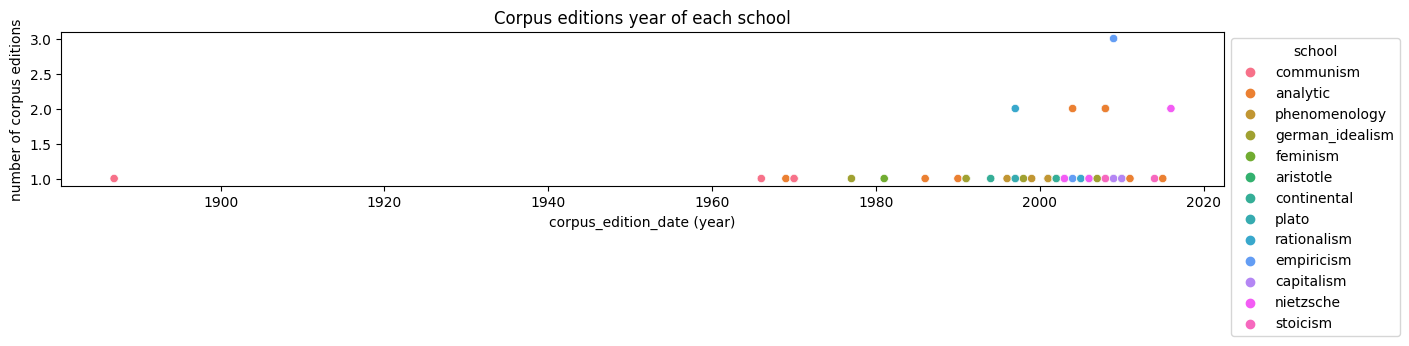

In [23]:
year = sorted(dfsent.original_publication_date.unique().tolist())
df_corpus = dfsent_len.groupby(['school','corpus_edition_date'])['title'].nunique().reset_index()
#df_corpus['corpus_edition_date']=pd.to_datetime(df_corpus['corpus_edition_date'], format='%Y')
df_corpus = df_corpus.sort_values('corpus_edition_date').reset_index()
plt.figure(figsize=(15,2))
plt.title('Corpus editions year of each school')
plot2 = sns.scatterplot(x='corpus_edition_date', y="title", hue="school", data=df_corpus)
plot2.set(xlabel='corpus_edition_date (year)',ylabel='number of corpus editions')
sns.move_legend(plot2, "upper left", bbox_to_anchor=(1, 1))

The previous figures are about philosophy books original publication year, here we have a scatter polt showing the corpus edition year of books in each school. We can see that more corpus editions happened in recent years. It could be because of people's increasing awareness of studying philosophy and understanding the society, history and human nature. 

# What do we learn so far?

- The main philosophy topics in 13 school of thoughts.
- The sentiment of philosophy text in schools of thoughts is mostly positive emotion.
- The speech style in philosophy text of school of thoughts and who made major contributions to each school in terms of number of sentences.
- The development of philosophy in each school over time. 

Philosophy is important for developing critical thinking skills, understanding the nature of reality and personal growth. Also, it has such an abudent history!